# Deep aggregation with CoNAL (Common Noise Adaptation Layer)

In [1]:
import numpy as np
from pathlib import Path

In [2]:
DIR = Path().cwd()
DIRlabelme = (DIR / ".." / "datasets" / "labelme").resolve()
DIR_module = DIRlabelme / "labelme.py"
DIR_answers = DIRlabelme / "answers.json"
print(DIRlabelme)

/home/tlefort/Documents/peerannot/peerannot/datasets/labelme


# Running CoNAL CLI

In [ ]:
! peerannot aggregate-deep -h

The following command is an example on how to train CoNAL on labelme, but it is not advised to run it here (long and costly)

```shell
peerannot aggregate-deep $DIRlabelme -o labelme_conal --answers $DIR_answers -s conal[scale=1e-5] \
    --model modellabelme --img-size=224 --pretrained --n-classes=8 \
    --n-epochs=1000 --lr=5e-3 --optimizer=adam \
    --batch-size=32 --num-workers=8 --data-augmentation
```

# Loading pretrained CoNAL

In [27]:
# Download model from
# "https://postechackr-my.sharepoint.com/personal/shhj1998_postech_ac_kr/_layouts/15/download.aspx?SourceUrl=%2Fpersonal%2Fshhj1998%5Fpostech%5Fac%5Fkr%2FDocuments%2F%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8%2F%EB%8C%80%ED%95%99%EC%9B%90%2F%ED%81%AC%EB%9D%BC%EC%9A%B0%EB%93%9C%EC%86%8C%EC%8B%B1%2Fcheckpoints%2Flabelme%2Dv4%2Fbest%5Fmodel%2Epth",

In [33]:
import torch
from peerannot.models.CoNAL import CoNAL_net
from peerannot.helpers.networks import networks
clf = networks("modellabelme", n_classes=8)
checkpoint = torch.load(DIRlabelme / "best_models" / "pretrained_conal.pth")

Using cache found in /home/tlefort/.cache/torch/hub/pytorch_vision_main


Successfully loaded modellabelme with n_classes=8


In [31]:
conal

CoNAL_net(
  (auxiliary_network): AuxiliaryNetwork(
    (weight_v1): Linear(in_features=150528, out_features=128, bias=True)
    (weight_v2): Linear(in_features=128, out_features=20, bias=True)
    (weight_u): Linear(in_features=59, out_features=20, bias=True)
    (activation): Sigmoid()
  )
  (noise_adaptation_layer): NoiseAdaptationLayer()
)

In [35]:
conal = CoNAL_net(input_dim=int(224 * 3 * 224),
                  n_class=8,
                  n_annotator=59,
                  classifier=clf,
                  annotator_dim=59,
                  embedding_dim=20)
conal.classifier.load_state_dict(checkpoint["classifier"])
conal.auxiliary_network.load_state_dict(checkpoint["auxiliary_network"])
conal.noise_adaptation_layer.load_state_dict(checkpoint["noise_adaptation_layer"])

<All keys matched successfully>

In [36]:
conf_local = conal.noise_adaptation_layer.local_confusion_matrices.detach().numpy()  # Confusion matrices of each annotator
conf_global = conal.noise_adaptation_layer.global_confusion_matrix.detach().numpy()   # Confusion matrix of common noise

# Visualize confusion matrices with CoNAL

In [37]:
import matplotlib.pyplot as plt

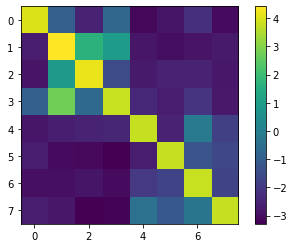

In [40]:
plot = plt.imshow(conf_global)
plt.colorbar(plot)

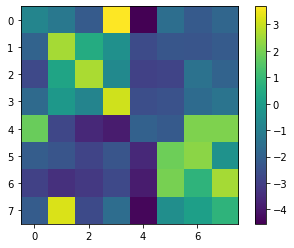

In [43]:
plot_w = conf_local[2]
plot_w = plt.imshow(plot_w)
plt.colorbar(plot_w)